In [165]:
import re
import numpy as np
import pandas as pd
from scipy import sparse
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

In [200]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss, confusion_matrix

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

from sklearn.pipeline import Pipeline

In [167]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [168]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [169]:
classes = [x for x in train.columns if x not in ['id', 'comment_text']]

In [170]:
test.fillna(' ', inplace=True)
train.fillna(' ', inplace=True)

In [192]:
def clean_text(col):
    col = col.str.lower()
    col = col.replace(r'\n', ' ').replace(r'\t', ' ')
    col = col.replace(r'[^a-z\s]', '', regex=True)
    col = col.replace(r'\s+', ' ', regex=True)
    col = col.replace(r"([a-z]+?)\1+", r"\1\1", regex=True) # removes any repetitions of letters more than twice
    col = col.replace(r"\b(\w+)(\s)(\1\2?)+", r"\1", regex=True) # removes any repetitions of words more than once
    col = col.str.strip()
    return col

In [193]:
train['comment_text_clean'] = clean_text(train['comment_text'])
test['comment_text_clean'] = clean_text(test['comment_text'])

In [194]:
X_train_df, X_val_df, y_train, y_val = train_test_split(train['comment_text_clean'], 
                                                        train[classes], 
                                                        test_size=0.3)

In [195]:
class vectorizer():
    def __init__(self):
        self.vect_words = TfidfVectorizer(max_features=None, 
                                         analyzer='word', 
                                         ngram_range=(1, 1), 
                                         max_df=0.1, 
                                         min_df=10,
                                         stop_words='english',
                                         use_idf=True)
        self.vect_chars = TfidfVectorizer(max_features=None, 
                                         analyzer='char', 
                                         ngram_range=(1, 5), 
                                         max_df=1., 
                                         min_df=1,
                                         use_idf=True)
        
    def fit(self, col):
        self.vect_words.fit(col)
        self.vect_chars.fit(col)
        
    def transform(self, col):
        vec = sparse.hstack([self.vect_words.transform(col), 
                             self.vect_chars.transform(col)])
        return vec

In [196]:
vect = vectorizer()

In [197]:
vect.fit(X_train_df)

In [198]:
X_train = vect.transform(X_train_df)
X_val = vect.transform(X_val_df)

In [199]:
X_train.shape

(67095, 616551)

In [ ]:
# Pipeline([('selec', anova_filter), ('svc', clf)])

In [190]:
%%time
models = {}
feature_selector = {}
for toxicity in classes:
    feature_selector[toxicity] = SelectKBest(chi2, k=500).fit(X_train, y_train[toxicity])
    m = LogisticRegression(C=5.0, class_weight=None, n_jobs=1)  
    #m = RandomForestClassifier(n_estimators=200, 
    #                           max_depth=None, 
    #                           bootstrap=False,
    #                           n_jobs=-1,
    #                           verbose=0, 
    #                           warm_start=False, 
    #                           class_weight=None)
    #m = SVC(C=1.0, 
    #        kernel="rbf", 
    #        degree=3, 
    #        gamma="auto", 
    #        coef0=0.0, 
    #        probability=True,
    #        class_weight=None, 
    #        verbose=True)
    m.fit(feature_selector[toxicity].transform(X_train), y_train[toxicity])
    models[toxicity] = m
    print("Model for %s trained" % toxicity, flush=True)

Model for toxic trained
Model for severe_toxic trained
Model for obscene trained
Model for threat trained
Model for insult trained
Model for identity_hate trained
CPU times: user 53.1 s, sys: 752 ms, total: 53.9 s
Wall time: 53.9 s


In [191]:
predictions = pd.DataFrame()
predictions_tr = pd.DataFrame()
loss = 0
loss_tr = 0
for toxicity in classes:
    predictions[toxicity] = models[toxicity].predict_proba(feature_selector[toxicity].transform(X_val))[:, 1]
    predictions_tr[toxicity] = models[toxicity].predict_proba(feature_selector[toxicity].transform(X_train))[:, 1]
    print(toxicity)
    ll = log_loss(y_val[toxicity], predictions[toxicity])
    ll_tr = log_loss(y_train[toxicity], predictions_tr[toxicity])
    print('test log-loss: %s' % str(ll.round(3)))
    print('train log-loss: %s' % str(ll_tr.round(3)))
    loss = loss + ll
    loss_tr = loss_tr + ll_tr
    print('test confusion matrix')
    print(confusion_matrix(y_val[toxicity], models[toxicity].predict(feature_selector[toxicity].transform(X_val))))
print('test mean log-loss: %s' % str(loss/6.))
print('train mean log-loss: %s' % str(loss_tr/6.))

toxic
test log-loss: 0.123
train log-loss: 0.119
test confusion matrix
[[25770   217]
 [  970  1799]]
severe_toxic
test log-loss: 0.029
train log-loss: 0.025
test confusion matrix
[[28393    62]
 [  220    81]]
obscene
test log-loss: 0.061
train log-loss: 0.056
test confusion matrix
[[27077   143]
 [  415  1121]]
threat
test log-loss: 0.014
train log-loss: 0.009
test confusion matrix
[[28641    12]
 [   84    19]]
insult
test log-loss: 0.08
train log-loss: 0.077
test confusion matrix
[[27146   220]
 [  594   796]]
identity_hate
test log-loss: 0.029
train log-loss: 0.025
test confusion matrix
[[28471    24]
 [  195    66]]
test mean log-loss: 0.0563058328425
train mean log-loss: 0.0519060591952


In [56]:
df = pd.DataFrame(X_val_df.reset_index(drop=True))
df['label'] = y_val['toxic'].reset_index(drop=True)
df['pred'] = predictions['toxic']

In [75]:
def generate_cloud(col):
    text = '.. '.join(list(col))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

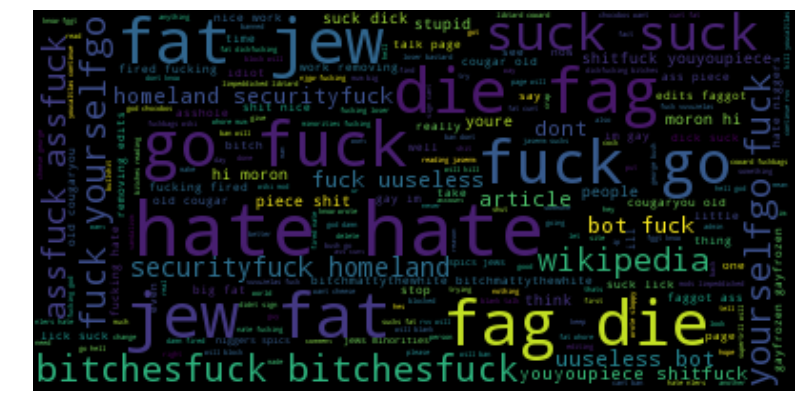

In [76]:
generate_cloud(df[(df.label==1) & (df.pred>0.5)].comment_text_clean)

In [80]:
df[df.comment_text_clean.str.contains('hate u')]

,comment_text_clean,label,pred
22272,the whole article is only from the liberal bib...,0,0.088929
28259,i left u a message and who does ur hair jk i h...,1,0.919360


In [156]:
df[(df.label==0) & (df.pred>0.5)].comment_text_clean.iloc[107]

'report this tootell them that they are gods peons that they cant help themselves they are depraved reprobate beasts who will be destroyed hell awaits this site is biased and run by satan every degenerate pervert in the world has his website linked here except for phelpsphelps only has mockery sins of himbukkake only has positivelyreviewed articles and porn pageswhoever bans me may he know that hes the basest of all perverts'

In [161]:
train[train.comment_text.str.contains('I promise you')]['comment_text'].iloc[0]

'The solution without a reference \n\n  //  Y1+\n  //  =/=N0      \n M1\n\nN0 never produces an output. The algorithm always produces a “M1” result when the answer is “Yes” from the oracle queried, and never produces a result when the answer is “N0” even to the other possible phrasings of the same query. It is striking how easy it is to miss the ingenuity of our programmers here. Most of the solution was already present as much as the pioneers and experts in the field surmised and asserted possible. Particularly, the comment on Fermat’s Last Theorem is relevantly applicable, such deep theories are in many instances required to solve largely thought unsolvable problems, especially in cases when most of the solution and the proof in the word was already known to the experts in the field.\n\nThe algorithm answers “Yes” with “M1” when the output produced from a correctly asked question produces never a “No” (written as N0) result, but only a “Yes” result. Incorrectly stated questions are t

# predictions on the test set

In [ ]:
Xtest = vect.transform(test['comment_text_clean'])

In [ ]:
predictions = pd.DataFrame(test.id)
for toxicity in classes:
    predictions[toxicity] = models[toxicity].predict_proba(feature_selector[toxicity].transform(Xtest))[:, 1]

In [ ]:
predictions.to_csv(datetime.now().strftime('%Y%m%d%H%M')+'_submission.csv', index=False)